<a href="https://colab.research.google.com/github/antonia-04/Gene-Explorer-PoliHack-V17/blob/main/AI_laborator_5_2_cu_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laborator 5 - Rezolvarea unor probleme de regresie prin metode de învățare automată

#### Folosind datele aferente anului 2017 (fisierul v2_world-happiness-report-2017.csv), să se realizeze o predicție a gradului de fericire în funcție doar de Produsul intern brut

In [ ]:
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, metrics

In [ ]:
def standardNormalize(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalizedData = (data - mean) / std_dev
    return normalizedData

In [ ]:
def normalizeData(data):
    rdata = [(x-min(data))/(max(data)-min(data)) for x in data]
    return rdata

In [ ]:
def loadData(fileName, outputVariabName, inputVariabName1, inputVariabName2 = None):
    data = []
    dataNames = []
    with open(fileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
            else:
                data.append(row)
            line_count += 1


    selectedOutput = dataNames.index(outputVariabName)
    outputs = [float(row[selectedOutput]) for row in data]
    outputs = standardNormalize(outputs)


    selectedVariable1 = dataNames.index(inputVariabName1)
    inputs1 = [float(row[selectedVariable1]) if row[selectedVariable1] != '' else None for row in data]
    mean_value1 = sum([val for val in inputs1 if val is not None]) / len([val for val in inputs1 if val is not None])
    for i in range(len(inputs1)):
        if inputs1[i] is None:
            inputs1[i] = mean_value1
    inputs1 = standardNormalize(inputs1)

    inputs2 = []

    if inputVariabName2 != None:
      selectedVariable2 = dataNames.index(inputVariabName2)
      inputs2 = [float(row[selectedVariable2]) if row[selectedVariable2] != '' else None for row in data]
      mean_value2 = sum([val for val in inputs2 if val is not None]) / len([val for val in inputs2 if val is not None])
      for i in range(len(inputs2)):
        if inputs2[i] is None:
            inputs2[i] = mean_value2
      inputs2 = standardNormalize(inputs2)

    if not len(inputs2):
      return outputs, inputs1
    else:
      return outputs, inputs1, inputs2

In [ ]:
def plotDataHistogram(x, variableName):
    n, bins, patches = plt.hist(x, 10)
    plt.title('Histogram of ' + variableName)
    plt.show()

In [ ]:
def plotData(x1, y1, x2 = None, y2 = None, x3 = None, y3 = None, title = None):
    plt.plot(x1, y1, 'ro', label = 'train data')
    if (x2):
        plt.plot(x2, y2, 'b-', label = 'learnt model')
    if (x3):
        plt.plot(x3, y3, 'g^', label = 'test data')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def splitData(inputs, outputs):
  # split data into training data (80%) and testing data (20%)
  np.random.seed(5)
  indexes = [i for i in range(len(inputs))]
  trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
  validationSample = [i for i in indexes  if not i in trainSample]
  trainInputs = [inputs[i] for i in trainSample]
  trainOutputs = [outputs[i] for i in trainSample]
  validationInputs = [inputs[i] for i in validationSample]
  validationOutputs = [outputs[i] for i in validationSample]
  return trainInputs, trainOutputs, validationInputs, validationOutputs

In [ ]:
def plotModel(trainInputs, trainOutputs, w0, w1):
  noOfPoints = 1000
  xref = []
  val = min(trainInputs)
  step = (max(trainInputs) - min(trainInputs)) / noOfPoints
  for i in range(1, noOfPoints):
      xref.append(val)
      val += step
  yref = [w0 + w1 * el for el in xref]
  plotData(trainInputs, trainOutputs, xref, yref, [], [], title = "train data and model")

In [ ]:
def computeError(validationOutputs, computedValidationOutputs):
  error = 0.0
  for t1, t2 in zip(computedValidationOutputs, validationOutputs):
      error += (t1 - t2) ** 2
  error = error / len(validationOutputs)
  print("prediction error (manual): ", error)

  error = metrics.mean_squared_error(validationOutputs, computedValidationOutputs)
  print("prediction error (tool): ", error)

In [ ]:
def makePrediction(filePath, inputVariable, outputVariable):
  outputs, inputs = loadData(filePath, outputVariable, inputVariable, inputVariabName2=None)

  plotDataHistogram(inputs, inputVariable)
  plotDataHistogram(outputs, outputVariable)

  # check the liniarity (to check that a linear relationship exists between the dependent variable (y) and the independent variable (x)
  plotData(inputs, outputs, [], [], [], [], inputVariable + " vs. " + outputVariable)

  # split data into training data (80%) and testing data (20%)
  trainInputs, trainOutputs, validationInputs, validationOutputs = splitData(inputs,outputs)
  plotData(trainInputs, trainOutputs, [], [], validationInputs, validationOutputs, "train and test data")

  # training step
  xx = [[el] for el in trainInputs]
  regressor = linear_model.LinearRegression()
  # regressor = linear_model.SGDRegressor(max_iter =  10000)
  regressor.fit(xx, trainOutputs)
  w0, w1 = regressor.intercept_, regressor.coef_

  # plot the model
  plotModel(trainInputs, trainOutputs, w0, w1)

  # use the trained model to predict new inputs

  # makes predictions for test data (manual)
  # computedTestOutputs = [w0 + w1 * el for el in testInputs]

  # makes predictions for test data (by tool)
  computedValidationOutputs = regressor.predict([[x] for x in validationInputs])

  # plot the computed outputs (see how far they are from the real outputs)
  plt.plot(validationInputs, computedValidationOutputs, 'yo', label = 'computed test data')  #computed test data are plotted yellow red and circle sign
  plt.plot(validationInputs, validationOutputs, 'g^', label = 'real test data')  #real test data are plotted by green triangles
  plt.title('computed validation and real validation data')
  plt.xlabel('GDP capita')
  plt.ylabel('happiness')
  plt.legend()
  plt.show()

  #compute the differences between the predictions and real outputs
  computeError(validationOutputs, computedValidationOutputs)

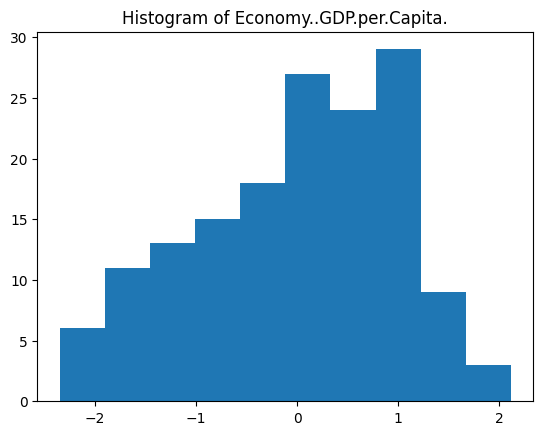

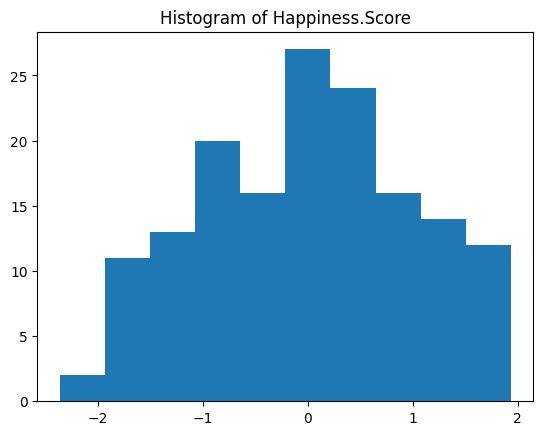

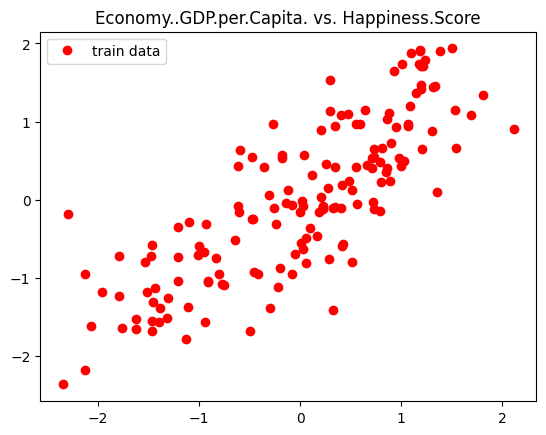

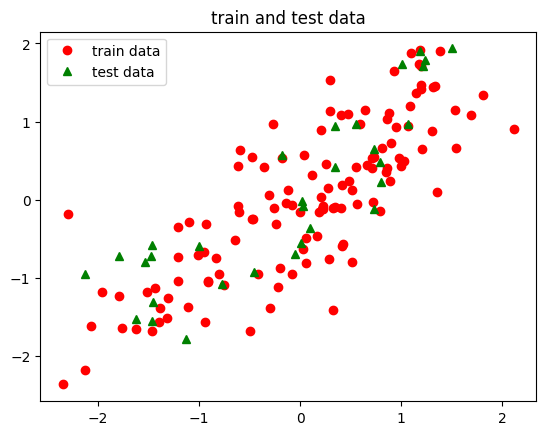

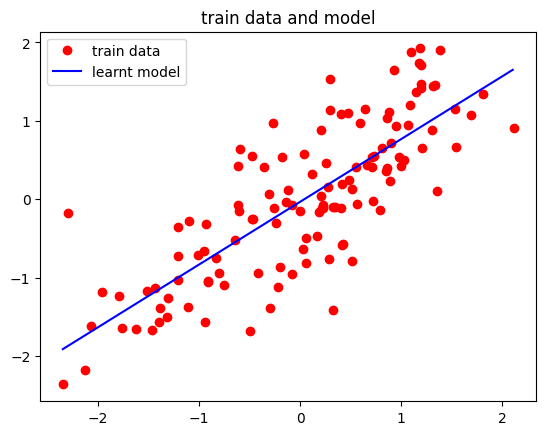

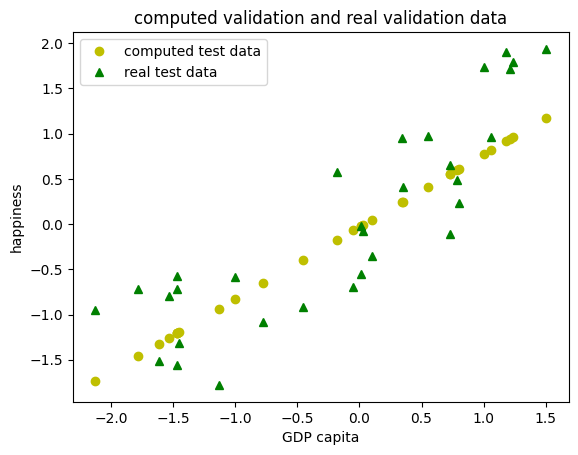

prediction error (manual):  0.32578553890299705
prediction error (tool):  0.325785538902997


In [ ]:
filePath = "/content/v2_world-happiness-report-2017.csv"

inputVariable = 'Economy..GDP.per.Capita.'
outputVariable = 'Happiness.Score'

makePrediction(filePath, inputVariable, outputVariable)

#### Folosind datele aferente anului 2017 (fisierul v2_world-happiness-report-2017.csv), să se realizeze o predicție a gradului de fericire în funcție doar de caracteristica "Family"

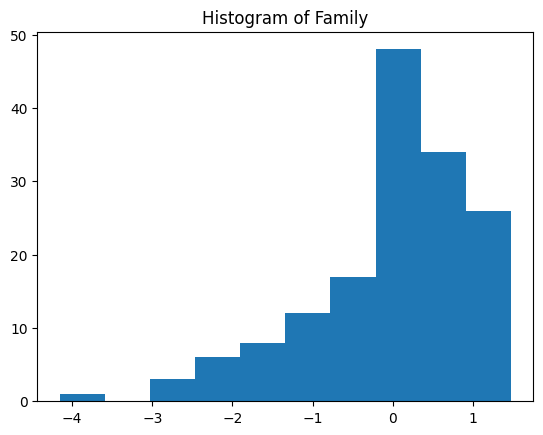

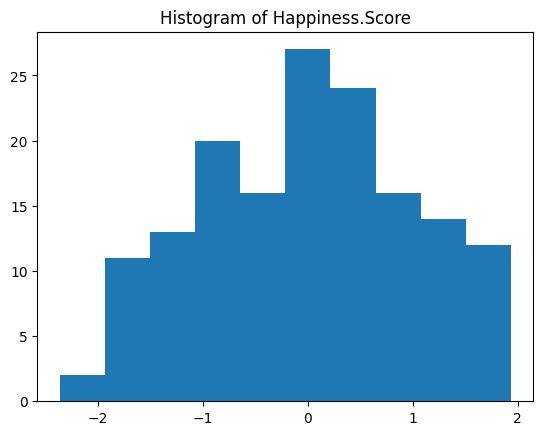

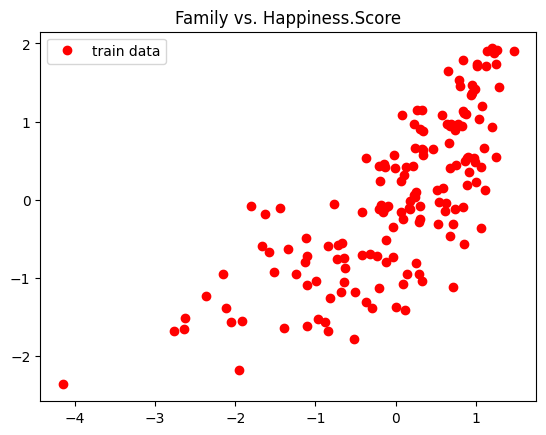

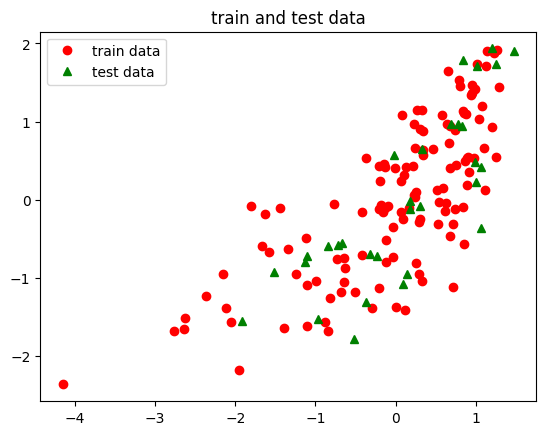

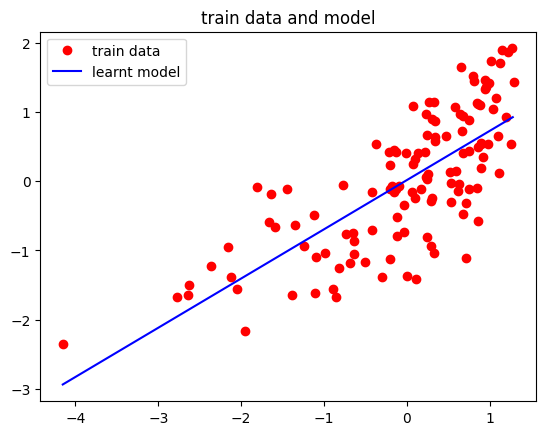

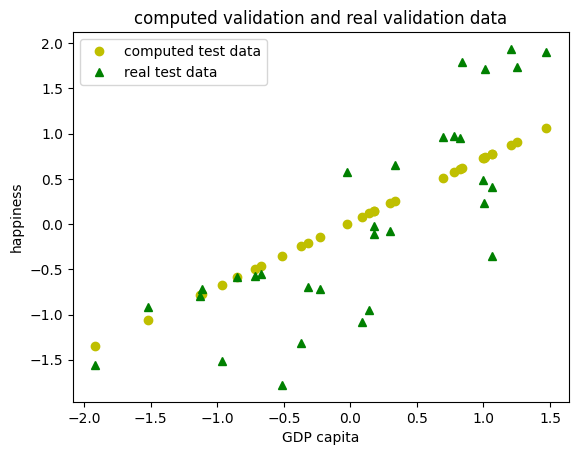

prediction error (manual):  0.4759406739873593
prediction error (tool):  0.4759406739873593


In [ ]:
filePath = "/content/v2_world-happiness-report-2017.csv"

inputVariable = 'Family'
outputVariable = 'Happiness.Score'

makePrediction(filePath, inputVariable, outputVariable)

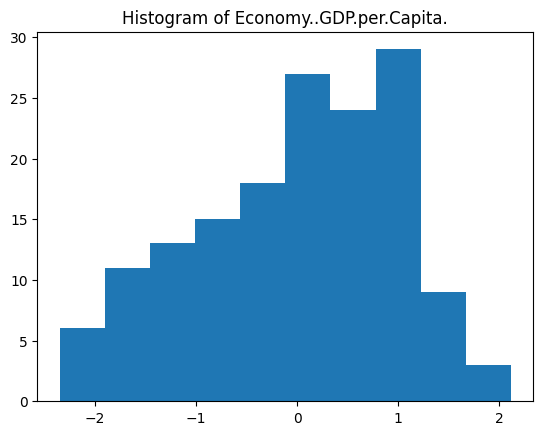

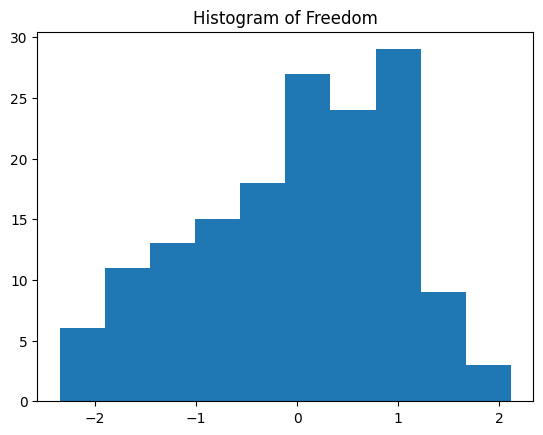

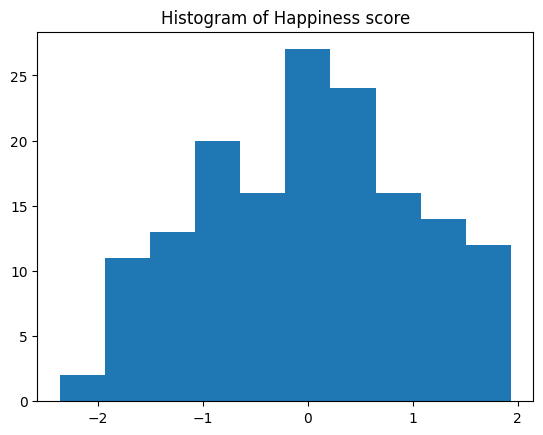

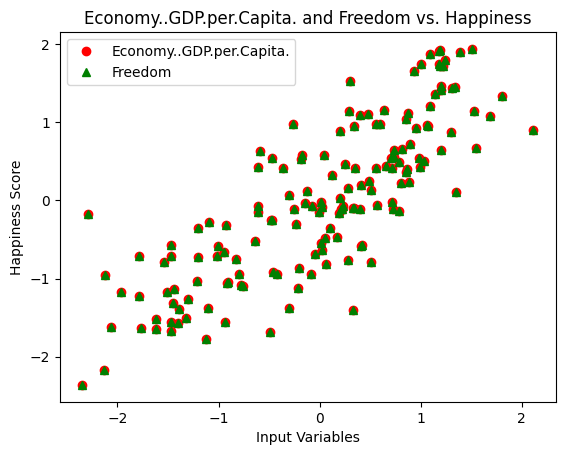

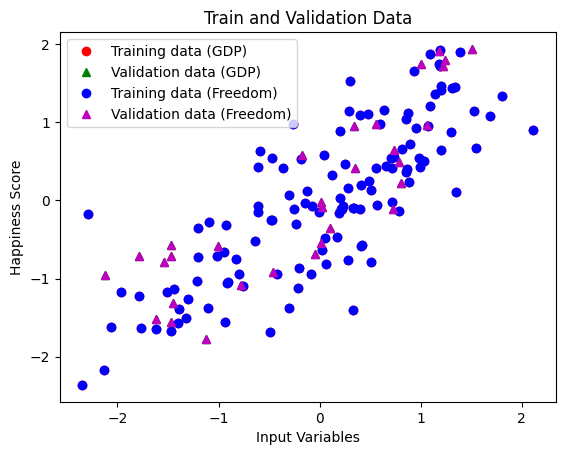

The learnt model: f(x1, x2) =  -0.03171845034372571  +  -25527.075290974703  * x1 +  25527.87517545569  * x2


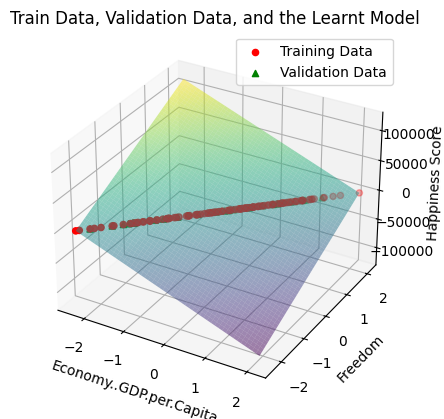

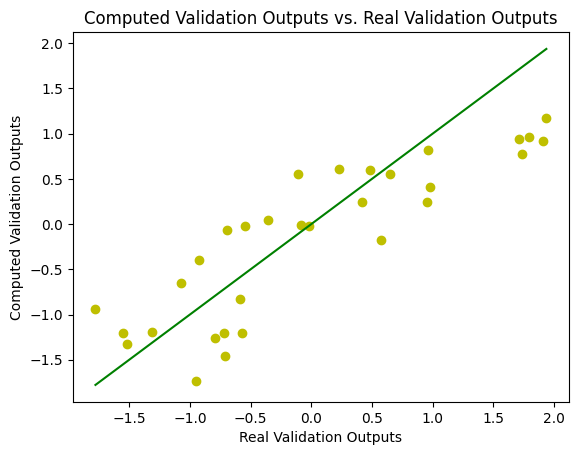

prediction error (manual):  0.3257841222679867
prediction error (tool):  0.3257841222679867


In [ ]:
filePath = "/content/v2_world-happiness-report-2017.csv"

inputVariable1 = 'Economy..GDP.per.Capita.'
inputVariable2 = 'Freedom'
outputVariable = 'Happiness.Score'

outputs, inputs1, inputs2 = loadData(filePath, outputVariable, inputVariable1, inputVariable2)

plotDataHistogram(inputs1, 'Economy..GDP.per.Capita.')
plotDataHistogram(inputs2, 'Freedom')
plotDataHistogram(outputs, 'Happiness score')

# check the liniarity

plt.plot(inputs1, outputs, 'ro', label='Economy..GDP.per.Capita.')
plt.plot(inputs2, outputs, 'g^', label='Freedom')
plt.xlabel('Input Variables')
plt.ylabel('Happiness Score')
plt.title('Economy..GDP.per.Capita. and Freedom vs. Happiness')
plt.legend()
plt.show()

# combine inputs into one matrix
X = np.column_stack((inputs1, inputs2))

# split data into training data (80%) and testing data (20%)
np.random.seed(5)
indexes = np.arange(len(inputs1))

trainSample = np.random.choice(indexes, int(0.8 * len(inputs1)), replace=False)
validationSample = np.array([i for i in indexes if i not in trainSample])

trainInputs = X[trainSample]
trainOutputs = np.array([outputs[i] for i in trainSample])

validationInputs = X[validationSample]
validationOutputs = np.array([outputs[i] for i in validationSample])

# plot train and validation data
plt.plot(trainInputs[:,0], trainOutputs, 'ro', label='Training data (GDP)')
plt.plot(validationInputs[:,0], validationOutputs, 'g^', label='Validation data (GDP)')
plt.plot(trainInputs[:,1], trainOutputs, 'bo', label='Training data (Freedom)')
plt.plot(validationInputs[:,1], validationOutputs, 'm^', label='Validation data (Freedom)')
plt.title('Train and Validation Data')
plt.xlabel('Input Variables')
plt.ylabel('Happiness Score')
plt.legend()
plt.show()

# training step
regressor = linear_model.LinearRegression()
regressor.fit(trainInputs, trainOutputs)
w0, w1, w2 = regressor.intercept_, regressor.coef_[0], regressor.coef_[1]
print('The learnt model: f(x1, x2) = ', w0, ' + ', w1, ' * x1 + ', w2, ' * x2')

# prepare synthetic data for plotting the learnt model
noOfPoints = 1000
x1_values = np.linspace(min(inputs1), max(inputs1), noOfPoints)
x2_values = np.linspace(min(inputs2), max(inputs2), noOfPoints)
X1, X2 = np.meshgrid(x1_values, x2_values)
Y = w0 + w1 * X1 + w2 * X2

# plot the model
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trainInputs[:,0], trainInputs[:,1], trainOutputs, c='r', marker='o', label='Training Data')
ax.scatter(validationInputs[:,0], validationInputs[:,1], validationOutputs, c='g', marker='^', label='Validation Data')
ax.plot_surface(X1, X2, Y, alpha=0.5, cmap='viridis')
ax.set_xlabel('Economy..GDP.per.Capita.')
ax.set_ylabel('Freedom')
ax.set_zlabel('Happiness Score')
plt.title('Train Data, Validation Data, and the Learnt Model')
plt.legend()
plt.show()

# makes predictions for test data
computedValidationOutputs = regressor.predict(validationInputs)

# plot computed outputs vs real outputs
plt.plot(validationOutputs, computedValidationOutputs, 'yo')
plt.plot(validationOutputs, validationOutputs, 'g-')
plt.title('Computed Validation Outputs vs. Real Validation Outputs')
plt.xlabel('Real Validation Outputs')
plt.ylabel('Computed Validation Outputs')
plt.show()

computeError(validationOutputs, computedValidationOutputs)